# DQN Training
Training a DQN agent using custom gym environment and keras-rl2.

# Imports

In [148]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from gym import Env
from gym.spaces import Discrete, Box

from rl.agents import DQNAgent
from rl.policy import MaxBoltzmannQPolicy, BoltzmannQPolicy, LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory

## Functions

In [149]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), "valid") / w

# Environment

## Loading Shape Class

In [150]:
import sys  
sys.path.insert(0, "E:\Projects\Python\TetrisRoyaleRL")

from settings import *
from game_env.shapes import Shape

## Reworking the Environment

In [151]:
class GameEnv(Env):
    def __init__(self):
        # spaces
        self.action_space = Discrete(4)
        self.observation_space = Box(low=0.0, high=1.0, shape=(20, 10, 3))
        
        # state
        self.game_over = None

        # coord
        self.map = None

        # shape
        self.shape = None
        self.next_shape = None

        # init env
        self._state_gen()

    def _state_gen(self):
        self.game_over = False
        
        self.map = np.ones((GAME_SHAPE_TOP_HIDDEN + 20 + GAME_SHAPE_BORDERS,
                            GAME_SHAPE_BORDERS + 10 + GAME_SHAPE_BORDERS), dtype=np.int32)
        self.map[0: -GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS] = 0
        
        self.shape = Shape()
        self.next_shape = Shape()

    def _state_observe(self):
        # observable map
        temp_map = self.map[GAME_SHAPE_TOP_HIDDEN:-GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS].copy()
        
        # observation of cur shape on map
        temp_shape = np.zeros(self.map.shape)
        x0 = self.shape.x
        y0 = int(self.shape.y)
        this_shape = self.shape.get_shape()
        temp_shape[y0: y0 + this_shape.shape[0], x0: x0 + this_shape.shape[1]] += this_shape
        temp_shape = temp_shape[GAME_SHAPE_TOP_HIDDEN:-GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
        
        # next shape on map, assuming y0 = 0
        temp_next_shape = np.zeros((20, 10))
        x0 = self.next_shape.x
        next_shape = self.next_shape.get_shape()
        temp_next_shape[0: next_shape.shape[0], x0: x0 + next_shape.shape[1]] += next_shape

        return np.stack([temp_map, temp_shape, temp_next_shape], axis=-1).astype(np.float32)

    def render(self):
        pass
    
    def reset(self):
        # restart state
        self._state_gen()
        # not terminal
        return self._state_observe()

    def step(self, action):
        action = action + 1
        reward = 0.01
        # 0 is skip
        # 1 is left
        if action == 1:
            if self.can_move(self.shape.x - 1, int(self.shape.y), self.shape.get_shape()):
                self.shape.x -= 1
            else:
                #reward -= 1
                pass
        # 2 is right
        elif action == 2:
            if self.can_move(self.shape.x + 1, int(self.shape.y), self.shape.get_shape()):
                self.shape.x += 1
            else:
                #reward -= 1
                pass
        # 3 is down
        elif action == 3:
            if self.can_move(self.shape.x, int(self.shape.y + 1), self.shape.get_shape()):
                self.shape.y += 1
            else:
                #reward -= 1
                pass
        # 4 is rotate
        elif action == 4:
            if self.can_move(self.shape.x, int(self.shape.y), self.shape.get_rotated()):
                self.shape.rotate()
            else:
                #reward -= 1
                pass
        # move down
        if self.can_move(self.shape.x, int(self.shape.y + FALL_SPEED), self.shape.get_shape()):
            self.shape.y += FALL_SPEED
        else:
            reward += self.lock_figure()

            #reward for height of locked shapes
            #height = self.map[GAME_SHAPE_TOP_HIDDEN: -GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
            #height = np.where(height.sum(axis=1) == 0)[0]
            #reward += (height.size) / 5
        
        # reward for cleared rows
        reward += self.remove_full_rows()
        
        return self._state_observe(), reward, self.game_over, {}


    def at(self, x, y):
        return self.map[GAME_SHAPE_TOP_HIDDEN + y, GAME_SHAPE_BORDERS + x]

    def can_move(self, x0, y0, figure):
        temp = self.map.copy()
        temp[int(y0): int(y0 + figure.shape[0]), x0: x0 + figure.shape[1]] += figure
        if 2 in temp:
            return False
        else:
            return True

    def lock_figure(self):
        x = self.shape.x
        y = int(self.shape.y)
        figure = self.shape.get_shape()
        self.map[y: y + figure.shape[0], x: x + figure.shape[1]] += figure
        self.shape = self.next_shape
        self.next_shape = Shape()
        if y < GAME_SHAPE_TOP_HIDDEN:
            self.game_over = True
        return y - GAME_SHAPE_TOP_HIDDEN


    def remove_full_rows(self):
        reward = 0
        full = self.map[GAME_SHAPE_TOP_HIDDEN: -GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
        full = np.where(full.sum(axis=1) == 10)[0]
        if full.size > 0:
            reward = full.size * 10

            # to get indexes of the game screen
            full = full + GAME_SHAPE_TOP_HIDDEN

            # remove full rows
            self.map[full, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS] = 0

            # get non-empty rows
            partial = self.map[GAME_SHAPE_TOP_HIDDEN: -GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
            partial = np.where(partial.sum(axis=1) != 0)[0]

            # if there are levitating non-empty rows
            if partial.size > 0:
                # get their indexes
                partial = partial + GAME_SHAPE_TOP_HIDDEN
                bottom = self.map.shape[0] - GAME_SHAPE_BORDERS
                # move them to bottom
                self.map[bottom-partial.size: bottom, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS] = \
                    self.map[partial, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
                # everything above must be cleared
                self.map[0: bottom-partial.size, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS] = 0
        return reward

## Create env

In [152]:
env = GameEnv()

## Test Random

In [153]:
episodes = 25
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    steps = 0
    while not done:
        action = np.random.randint(0, 4)
        n_state, reward, done, info = env.step(action)
        score+=reward
        steps +=1
    print("Episode: {}, Score: {}, Steps: {}".format(episode, score, steps))

Episode: 1, Score: 134.78000000000034, Steps: 578
Episode: 2, Score: 241.17999999999628, Steps: 1018
Episode: 3, Score: 249.0999999999964, Steps: 1010
Episode: 4, Score: 208.48999999999742, Steps: 849
Episode: 5, Score: 223.25999999999652, Steps: 926
Episode: 6, Score: 176.21999999999895, Steps: 722
Episode: 7, Score: 176.75999999999834, Steps: 776
Episode: 8, Score: 170.54999999999947, Steps: 655
Episode: 9, Score: 219.22999999999703, Steps: 923
Episode: 10, Score: 208.10999999999734, Steps: 911
Episode: 11, Score: 247.28999999999672, Steps: 1029
Episode: 12, Score: 211.3699999999972, Steps: 837
Episode: 13, Score: 218.20999999999685, Steps: 921
Episode: 14, Score: 214.779999999998, Steps: 878
Episode: 15, Score: 176.20999999999904, Steps: 721
Episode: 16, Score: 264.35999999999615, Steps: 1036
Episode: 17, Score: 224.6099999999974, Steps: 861
Episode: 18, Score: 223.87999999999676, Steps: 888
Episode: 19, Score: 155.2799999999996, Steps: 628
Episode: 20, Score: 242.2899999999959, Ste

## Test do-nothing

In [154]:
episodes = 25
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    steps = 0
    while not done:
        action = 0
        n_state, reward, done, info = env.step(action)
        score+=reward
        steps +=1
    print("Episode: {}, Score: {}, Steps: {}".format(episode, score, steps))

Episode: 1, Score: 90.11000000000115, Steps: 911
Episode: 2, Score: 95.44000000000123, Steps: 944
Episode: 3, Score: 96.51000000000136, Steps: 951
Episode: 4, Score: 95.45000000000134, Steps: 945
Episode: 5, Score: 96.85000000000153, Steps: 985
Episode: 6, Score: 113.91000000000258, Steps: 1091
Episode: 7, Score: 93.31000000000121, Steps: 931
Episode: 8, Score: 104.32000000000178, Steps: 1032
Episode: 9, Score: 104.31000000000168, Steps: 1031
Episode: 10, Score: 95.45000000000134, Steps: 945
Episode: 11, Score: 116.0500000000025, Steps: 1105
Episode: 12, Score: 107.18000000000212, Steps: 1018
Episode: 13, Score: 97.59000000000191, Steps: 959
Episode: 14, Score: 112.85000000000244, Steps: 1085
Episode: 15, Score: 105.39000000000236, Steps: 1039
Episode: 16, Score: 94.3800000000012, Steps: 938
Episode: 17, Score: 94.37000000000124, Steps: 937
Episode: 18, Score: 97.5700000000014, Steps: 957
Episode: 19, Score: 102.91000000000211, Steps: 991
Episode: 20, Score: 105.05000000000214, Steps: 

# Nural Network and Agent

## Build model

In [155]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [156]:
def build_model():
    return tf.keras.Sequential([
    # 1 state, 20 rows, 10 cols, 3 matricies: locked, falling and next figures
    layers.Input(shape=(1, 20, 10, 3)),
    layers.Reshape(target_shape=(20, 10, 3)),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    
    layers.Dense(32),
    layers.Activation("relu"),
    
    layers.Dense(16),
    layers.Activation("relu"),
    
    layers.Dense(4)])

In [157]:
model = build_model()
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 20, 10, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 20, 10, 32)        896       
                                                                 
 activation_43 (Activation)  (None, 20, 10, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 10, 5, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 10, 5, 64)         18496     
                                                                 
 activation_44 (Activation)  (None, 10, 5, 64)         0         
                                                     

## Agent

In [158]:
env.observation_space.shape, env.action_space.n

((20, 10, 3), 4)

In [159]:
def build_agent(model):
    #policy = MaxBoltzmannQPolicy()
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), 
                              attr='eps',
                              value_max=1.0,
                              value_min=0.01,
                              value_test=.05,
                              nb_steps=75000)
    memory = SequentialMemory(limit=10000, window_length=1)
    dqn = DQNAgent(model=model, 
        memory=memory,
        policy=policy,
        nb_actions=4,
        nb_steps_warmup=256,
        batch_size=128,
        target_model_update=0.01,
        enable_double_dqn=True,
        enable_dueling_network=True)
    return dqn

In [160]:
dqn = build_agent(model)
dqn.compile(tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0), metrics=["mean_squared_error"])

In [161]:
#dqn.load_weights("saved/dqn_v6.h5")

#from keras import backend as K
#print(K.eval(dqn.model.optimizer.learning_rate))
#K.set_value(dqn.model.optimizer.learning_rate, 0.001)
#print(K.eval(dqn.model.optimizer.learning_rate))

## Training

In [162]:
history = dqn.fit(env, nb_steps=175000, visualize=False, verbose=1, log_interval=10000)

Training for 175000 steps ...
Interval 1 (0 steps performed)


E:\Programs\Anaconda\envs\game.ai\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10000/10000 [==============================] - 350s 35ms/step - reward: 0.2684
12 episodes - episode_reward: 209.466 [131.800, 265.910] - loss: 0.459 - mean_squared_error: 612.061 - mean_q: 25.343 - mean_eps: 0.932

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 384s 38ms/step - reward: 0.2872
13 episodes - episode_reward: 221.033 [177.290, 247.160] - loss: 0.374 - mean_squared_error: 1564.992 - mean_q: 44.209 - mean_eps: 0.802

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 391s 39ms/step - reward: 0.3086
14 episodes - episode_reward: 219.055 [159.010, 260.800] - loss: 0.247 - mean_squared_error: 1672.829 - mean_q: 44.470 - mean_eps: 0.670

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 398s 40ms/step - reward: 0.3486
17 episodes - episode_reward: 216.120 [168.720, 254.330] - loss: 0.198 - mean_squared_error: 1627.543 - mean_q: 42.401 - mean_eps: 0.538

Interval 5 (40000 steps perf

## Save Weights

In [163]:
dqn.save_weights("saved/dqn_v9.h5", overwrite=True)

## Plot

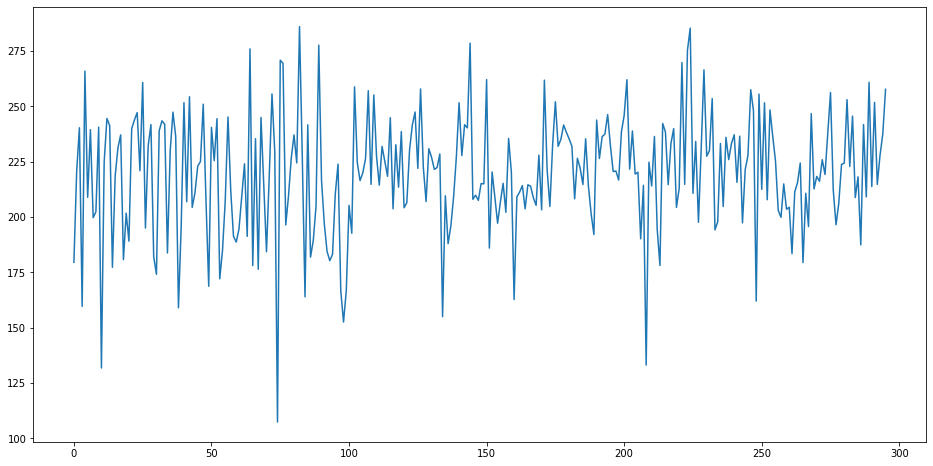

In [164]:
# load history
#full_hist = np.load("saved/history.npy")
# concat old and new history
#full_hist = np.concatenate((full_hist, np.array(history.history["episode_reward"])))
# save history
#np.save("saved/history.npy", full_hist)
np.save("saved/history8.npy", np.array(history.history["episode_reward"]))

plt.rcParams["figure.figsize"] = (16, 8)
#plt.plot(moving_average(full_hist, 10))
#plt.plot(full_hist)
plt.plot(np.array(history.history["episode_reward"]))
plt.show()